In [1]:
from pymystem3 import Mystem
import logging
import math
import pandas as pd
import re
from random import random, sample
from __future__ import print_function

import codecs
from functools import partial
open = partial(codecs.open, encoding="utf-8")

## Имена файлов

In [2]:
text_file = "data/war.txt"
pairs_with_gr_file = "data/pairs_with_grammar.tsv"
relations_pairs_file = "data/relations_pairs.tsv"
train_file = "data/train.csv"
test_file = "data/test.csv"
disperse_file = "data/disperse_data.tsv"

## Настройка логгера

In [3]:
logging.basicConfig(filename='preparation_results.log',
                    format='[%(asctime)s] [%(levelname)s] %(message)s',
                    level=logging.DEBUG)

lg = logging.getLogger("L")
lg.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s")
ch.setFormatter(formatter)
lg.addHandler(ch)

## Загрузка стеммера

In [4]:
lg.info("Loading mystem")
m = Mystem()
lg.info("Loaded mystem")

2016-11-12 01:21:46,828 [INFO] Loading mystem
2016-11-12 01:21:46,833 [INFO] Loaded mystem


## Вспомогательные функции

In [5]:
def parse_gr(gr):
    options = re.search('\(([^\)]*)\)', gr, re.IGNORECASE)

    if options:
        title = options.group(1)
        for stuff in title.split('|'):
            yield gr.replace("(" + title + ")", stuff)
    else:
        yield gr

## Запись пар с их грамматической информацией

Создаем множество кортежей типа  
(грамматическое описание, начальная форма, слово)

In [6]:
lines = set([])

with open(text_file, "rt") as input_file:
    lg.info("file opened")

    i = 0
    for line in input_file:
        for w in m.analyze(line):
            if i % 50000 == 0:
                lg.info("{} strings are processed".format(i))
            i += 1
            if 'analysis' in w:
                for item in w['analysis']:
                    for gramm_info in parse_gr(item['gr']):
                        lines.add(u"\t".join(
                            [gramm_info, item['lex'], w['text'].lower()]) + u"\n")

2016-11-12 01:21:50,319 [INFO] file opened
2016-11-12 01:21:52,744 [INFO] 0 strings are processed
2016-11-12 01:22:06,424 [INFO] 50000 strings are processed
2016-11-12 01:22:19,978 [INFO] 100000 strings are processed
2016-11-12 01:22:33,959 [INFO] 150000 strings are processed
2016-11-12 01:22:48,448 [INFO] 200000 strings are processed
2016-11-12 01:23:03,117 [INFO] 250000 strings are processed
2016-11-12 01:23:16,956 [INFO] 300000 strings are processed
2016-11-12 01:23:31,168 [INFO] 350000 strings are processed
2016-11-12 01:23:45,441 [INFO] 400000 strings are processed
2016-11-12 01:23:59,940 [INFO] 450000 strings are processed


Записываем их в файл pairs_with_grammar

In [7]:
with open(pairs_with_gr_file, "wt") as f:
    for line in lines:
        f.write(line)

## Запись данных для обучения

Читаем файл

In [8]:
dict = {}
n_trivial = 0
for line in open(pairs_with_gr_file, "rt"):
    if line.strip():
        desc, normal, form = line.strip().split("\t")
        if normal == form:
            n_trivial += 1
        if desc not in dict:
            dict[desc] = []
        dict[desc].append((normal, form))

lg.info("Pairs acquired")

2016-11-12 01:24:10,433 [INFO] Pairs acquired


Ограничиваем группы с одинаковым gr 

In [9]:
bound = 50

for desc in dict:
    if len(dict[desc]) > bound:
        dict[desc] = list(sample(dict[desc], bound))

И создаем декартово произведение пар (слово, нач. форма)

In [10]:
writer = open(relations_pairs_file, "w+")
for desc in dict:
    for p0 in dict[desc]:
        for p1 in dict[desc]:
            if not p0 == p1:
                writer.write("\t".join([p0[0], p0[1], p1[0], p1[1]]) + "\n")

writer.close()
lg.info("Relations pairs acquired")

2016-11-12 01:24:17,382 [INFO] Relations pairs acquired


Прорежаем данные, если нужно (уменьшаем размер в factor раз)

In [11]:
factor = 1

if factor != 1:
    with open(relations_pairs_file, "rt") as input_:
        with open(disperse_file, "wt") as output:
            for line in input_:
                if random() < (1.0 / factor):
                    output.write(line)
            lg.info("Use Disperse data")

Делим данные на данные для обучения и для тестирования (было в функции prepare_relations)

In [12]:
splitting = 0.9

n_train = 0
n_test = 0
with open(relations_pairs_file if factor == 1 else disperse_file, "rt") as data:
    with open(train_file, "wt") as train:
        with open(test_file, "wt") as test:
            for line in data:
                line = ",".join(line.split("\t"))
                if random() < splitting:
                    train.write(line)
                    n_train += 1
                else:
                    test.write(line) 
                    n_test += 1
            lg.info("Data acquired")

2016-11-12 01:24:33,534 [INFO] Data acquired


## Aditional information

In [13]:
lg.info("Всего строк: {}".format(len(lines)))
lg.info("Всего полезных строк: {}".format(sum(len(l) for l in dict)))
lg.info("Из них строк, где слово == нач. форма: {} то есть {}%".format(n_trivial, 100 * n_trivial // len(lines)))
lg.info("Групп с различным gr: {}".format(len(dict)))
lg.info("Размер максимальной группы: {}".format(max(len(l) for l in dict.values())))
lg.info("На выходе должно получиться: {} строк".format(sum(len(l) * (len(l) - 1) for l in dict.values()) // factor))
lg.info("Всего получилось {} строк из них {} для train'a и {} для test'a".format(n_test + n_train, n_train, n_test))

2016-11-12 01:24:33,554 [INFO] Всего строк: 50741
2016-11-12 01:24:33,560 [INFO] Всего полезных строк: 48056
2016-11-12 01:24:33,562 [INFO] Из них строк, где слово == нач. форма: 9869 то есть 19%
2016-11-12 01:24:33,565 [INFO] Групп с различным gr: 1706
2016-11-12 01:24:33,568 [INFO] Размер максимальной группы: 50
2016-11-12 01:24:33,572 [INFO] На выходе должно получиться: 623560 строк
2016-11-12 01:24:33,574 [INFO] Всего получилось 623560 строк из них 561269 для train'a и 62291 для test'a


In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/pavel/anaconda3/envs/with_python_2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'normal', 'random', 'sample', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 322.,  140.,   90.,   57.,   27.,   19.,   32.,   13.,    7.,
          20.,    6.,   10.,    7.,    3.,   11.,    8.,   10.,    4.,
           5.,    6.,    7.,    3.,    2.,    9.,    6.,    7.,    1.,
           4.,    0.,    2.,    4.,    1.,    0.,    4.,    2.,    4.,
           2.,    1.,    0.,    1.,    3.,    1.,    1.,    3.,    2.,
           1.,    1.,    2.,    4.,   67.]),
 array([  1.  ,   1.98,   2.96,   3.94,   4.92,   5.9 ,   6.88,   7.86,
          8.84,   9.82,  10.8 ,  11.78,  12.76,  13.74,  14.72,  15.7 ,
         16.68,  17.66,  18.64,  19.62,  20.6 ,  21.58,  22.56,  23.54,
         24.52,  25.5 ,  26.48,  27.46,  28.44,  29.42,  30.4 ,  31.38,
         32.36,  33.34,  34.32,  35.3 ,  36.28,  37.26,  38.24,  39.22,
         40.2 ,  41.18,  42.16,  43.14,  44.12,  45.1 ,  46.08,  47.06,
         48.04,  49.02,  50.  ]),
 <a list of 50 Patch objects>)

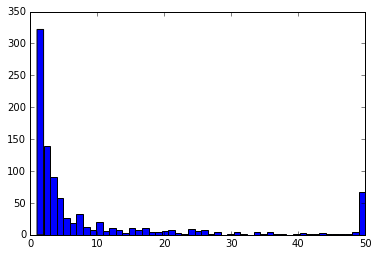

In [16]:
hist(np.array([len(value) for value in dict.values() if len(value) > 0]), 50)